In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.figsize'] = [8, 6]
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.grid'] = True

import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
torch.multiprocessing.set_start_method('spawn')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


import numpy as np
SEED=12345
_=np.random.seed(SEED)
_=torch.manual_seed(SEED)

import networkx as nx

from iftool.image_challenge import collate
from torch.utils.data import DataLoader

from iftool.image_challenge import ParticleImage2D
from torch_geometric.utils import from_networkx

## Load data

In [2]:
train_graphs = torch.load("/ssl-jet-vol-v2/ssi_2023_if_1/data/train_graphs_2.pt")

In [3]:
len(train_graphs)

40000

In [4]:
import copy
train_graphs_2 = copy.deepcopy(train_graphs)

In [5]:
for ele in train_graphs_2:
    ele['feature'] = torch.cat((ele['pos'],ele['value'].unsqueeze(1)),1)

In [9]:
train_graphs[0].value

tensor([0.9628, 0.8023, 0.6649, 0.7892, 0.3251, 0.8524, 1.4830, 1.0133, 1.4997,
        0.9602, 1.5116, 0.6796, 0.7355, 0.7868, 0.0714, 1.2852, 1.3699, 1.7569,
        1.0477, 1.4280, 0.7303, 0.7371, 1.6268, 1.0722, 1.1784, 1.0313, 0.5242,
        0.5049, 0.7870, 1.1632, 1.5814, 0.9802, 0.6228, 1.0249, 0.7819, 0.7958,
        1.2446, 0.6710, 0.6856, 0.4553, 1.0850, 1.6697, 1.6259, 0.8590, 0.4450,
        0.4016, 1.1119, 1.5500, 1.0051, 1.1685, 0.9726, 0.1833, 0.9611, 0.9167,
        0.3269, 0.8207, 0.8006, 0.8187, 1.8866, 0.0529, 0.9526, 1.5750, 1.3070,
        0.7487, 0.8135, 0.5991, 0.8314, 0.7211, 1.5039, 0.3189, 0.7763, 0.8615,
        0.6534, 0.7259, 0.8723, 0.9773, 0.7744, 2.0512, 0.3373, 2.7716, 0.9481,
        0.5705, 0.7127, 0.7428, 1.0449, 1.1759, 0.8223, 0.5689, 0.7686, 0.7397,
        0.1510, 0.9984, 1.9982, 0.8302, 0.8375, 0.8088, 1.4704, 1.1399, 1.4427,
        4.3531, 2.2879, 0.6414, 0.9365, 0.0526, 0.0768, 0.3296])

In [8]:
train_graphs_2[0].feature

tensor([[1.0400e+02, 7.7000e+01, 9.6275e-01],
        [1.0600e+02, 7.7000e+01, 8.0231e-01],
        [1.2000e+02, 7.6000e+01, 6.6489e-01],
        [1.2100e+02, 7.6000e+01, 7.8918e-01],
        [1.0000e+02, 7.6000e+01, 3.2514e-01],
        [1.0100e+02, 7.7000e+01, 8.5245e-01],
        [1.1500e+02, 7.6000e+01, 1.4830e+00],
        [1.1600e+02, 7.6000e+01, 1.0133e+00],
        [9.5000e+01, 7.6000e+01, 1.4997e+00],
        [9.6000e+01, 7.6000e+01, 9.6021e-01],
        [1.4300e+02, 7.7000e+01, 1.5116e+00],
        [1.4400e+02, 7.7000e+01, 6.7965e-01],
        [1.3200e+02, 7.6000e+01, 7.3546e-01],
        [1.3400e+02, 7.6000e+01, 7.8682e-01],
        [9.6000e+01, 7.7000e+01, 7.1438e-02],
        [9.8000e+01, 7.7000e+01, 1.2852e+00],
        [6.3000e+01, 7.7000e+01, 1.3699e+00],
        [6.4000e+01, 7.7000e+01, 1.7569e+00],
        [7.4000e+01, 7.6000e+01, 1.0477e+00],
        [7.6000e+01, 7.6000e+01, 1.4280e+00],
        [9.1000e+01, 7.6000e+01, 7.3025e-01],
        [9.2000e+01, 7.6000e+01, 7

In [10]:
val_ratio = 0.1
train_data = train_graphs_2[:int(len(train_graphs) * (1 - val_ratio))]
val_data = train_graphs_2[int(len(train_graphs) * (1 - val_ratio)):]

In [11]:
len(train_data)

36000

In [12]:
len(val_data)

4000

In [13]:
from torch_geometric.data import DataLoader

# Assuming list_of_data is your loaded list of Data objects
train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
val_loader = DataLoader(val_data, batch_size=256, shuffle=True)

/opt/conda/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [14]:
for batch in train_loader:
    break

In [15]:
batch.y

tensor([0, 0, 0, 0, 0, 0, 3, 0, 3, 1, 1, 1, 2, 0, 0, 2, 0, 2, 3, 3, 0, 2, 3, 1,
        1, 2, 1, 2, 2, 0, 2, 1, 3, 2, 0, 1, 3, 0, 2, 2, 1, 2, 1, 2, 0, 1, 1, 1,
        3, 2, 1, 3, 1, 2, 1, 3, 2, 3, 2, 2, 2, 2, 3, 0, 0, 1, 2, 0, 1, 3, 0, 3,
        0, 1, 0, 0, 2, 3, 2, 2, 0, 3, 0, 2, 2, 0, 1, 0, 2, 2, 3, 2, 0, 1, 1, 3,
        1, 3, 1, 2, 2, 3, 1, 0, 1, 2, 1, 2, 0, 2, 3, 0, 2, 1, 0, 3, 3, 1, 2, 1,
        1, 0, 3, 3, 3, 0, 3, 1, 2, 3, 2, 0, 0, 2, 1, 1, 0, 0, 1, 3, 3, 2, 1, 1,
        3, 0, 0, 0, 2, 3, 2, 2, 3, 3, 0, 3, 1, 1, 2, 3, 0, 1, 0, 0, 2, 1, 2, 0,
        2, 2, 1, 0, 2, 1, 0, 0, 1, 2, 3, 1, 1, 1, 3, 2, 1, 0, 0, 2, 3, 3, 2, 2,
        2, 3, 2, 0, 2, 3, 0, 3, 0, 0, 1, 0, 3, 3, 0, 0, 1, 3, 1, 3, 0, 3, 2, 2,
        1, 3, 0, 2, 2, 0, 1, 2, 3, 3, 0, 3, 3, 0, 0, 2, 1, 0, 1, 2, 3, 0, 1, 2,
        3, 0, 1, 3, 2, 0, 0, 0, 2, 1, 2, 2, 0, 2, 1, 0])

In [16]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GraphConv, GATConv
from torch_geometric.nn import global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(1, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 4)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = x.reshape(-1, 1)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [48]:
class GrCN(torch.nn.Module):
    def __init__(self, hidden_channels, input_channels=1):
        super(GrCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(input_channels, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 4)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
#         x = x.reshape(-1, 1)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [35]:
class GATCN(torch.nn.Module):
    def __init__(self, hidden_channels, input_channels=1):
        super(GATCN, self).__init__()
        torch.manual_seed(12345)
        self.hidden_channels = hidden_channels
        self.conv1 = GATConv(input_channels, hidden_channels, heads=1, concat=False)
        self.conv2 = GATConv(hidden_channels, hidden_channels, heads=2, concat=False)
        self.conv3 = GATConv(hidden_channels, hidden_channels, heads=2, concat=False)
        self.lin = Linear(hidden_channels, 4)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
#         x = x.reshape(-1, 1)
        x = self.conv1(x, edge_index)
        x = x.relu()
#         x = self.conv2(x, edge_index).reshape(-1, self.hidden_channels*2)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [42]:
class GrCN_2(torch.nn.Module):
    def __init__(self, hidden_channels, input_channels=1):
        super(GrCN_2, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(input_channels, int(hidden_channels / 2))
        self.conv2 = GraphConv(int(hidden_channels / 2), hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.conv4 = GraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 4)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
#         x = x.reshape(-1, 1)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [36]:
import os
input_channels = 3
model = GATCN(hidden_channels=128, input_channels=input_channels).to(device)
prev_label = "GATConv_w_pos"
model_loc = f"/ssl-jet-vol-v2/ssi_2023_if_1/models/trained_models/GNN_{prev_label}_best.pth"
trained_model_dict = torch.load(model_loc)
model.load_state_dict(trained_model_dict)

<All keys matched successfully>

In [49]:
input_channels = 3
model = GrCN(hidden_channels=128, input_channels=input_channels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

batch_size=256
label = "GraphConv_w_pos"
outdir = "/ssl-jet-vol-v2/ssi_2023_if_1/models"
model_loc = f"{outdir}/trained_models"
model_perf_loc = f"{outdir}/model_performances/{label}"

os.system(
        f"mkdir -p {model_loc} {model_perf_loc}"
    )  # -p: create parent dirs if needed, exist_ok

train_its = int(len(train_data) / batch_size)
val_its = int(len(val_data) / batch_size)

train_losses = []
val_losses = []
val_accs = []
val_acc_best = 0
epochs = 50

for epoch in range(epochs):
    l_train_epoch = []
    l_val_epoch = []
    model.train()
    pbar = tqdm.tqdm(train_loader, total=train_its)
    for _, bb in enumerate(pbar):
        bb.to(device)
        out = model(bb.feature, bb.edge_index, bb.batch)  # Perform a single forward pass.
        loss = criterion(out, bb.y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss = loss.detach().cpu().item()
        l_train_epoch.append(loss)
        pbar.set_description(f"Training loss: {loss:.4f}")

    l_train = np.mean(l_train_epoch)
    train_losses.append(l_train)
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {l_train:.4f} ")

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        pbar = tqdm.tqdm(val_loader, total=val_its)
        for i, bb in enumerate(pbar):
            bb.to(device)
            out = model(bb.feature, bb.edge_index, bb.batch)  # Perform a single forward pass.
            loss = criterion(out, bb.y)
            
            
            labels = bb.y
            loss = loss.detach().cpu().item()
            l_val_epoch.append(loss)
            pbar.set_description(f"Validation loss: {loss:.4f}")
            _, predicted = torch.max(out.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            

    val_acc = correct / total
    print(f"val accuracy: {val_acc}")
    val_accs.append(val_acc)

    l_val = np.mean(l_val_epoch)
    print(f"Epoch [{epoch+1}/{epochs}], Val Loss: {l_val:.4f} ")
    if val_acc > val_acc_best:
        val_acc_best = val_acc
        print("new best model")
        torch.save(model.state_dict(), f"{model_loc}/GNN_{label}_best.pth")
    torch.save(model.state_dict(), f"{model_loc}/GNN_{label}_last.pth")
    val_losses.append(l_val)



Training loss: 0.7347: : 141it [00:03, 35.42it/s]                                                                                      


Epoch [1/50], Train Loss: 26.0986 


Validation loss: 0.6587: : 16it [00:00, 33.40it/s]                                                                                     


val accuracy: 0.699
Epoch [1/50], Val Loss: 0.6580 
new best model


Training loss: 0.8250: : 141it [00:03, 36.24it/s]                                                                                      


Epoch [2/50], Train Loss: 0.7844 


Validation loss: 0.6916: : 16it [00:00, 37.62it/s]                                                                                     


val accuracy: 0.73225
Epoch [2/50], Val Loss: 0.6167 
new best model


Training loss: 0.6974: : 141it [00:04, 33.95it/s]                                                                                      


Epoch [3/50], Train Loss: 0.6901 


Validation loss: 0.5605: : 16it [00:00, 41.90it/s]                                                                                     


val accuracy: 0.7465
Epoch [3/50], Val Loss: 0.5701 
new best model


Training loss: 0.6268: : 141it [00:04, 33.24it/s]                                                                                      


Epoch [4/50], Train Loss: 0.6422 


Validation loss: 0.4788: : 16it [00:00, 31.52it/s]                                                                                     


val accuracy: 0.747
Epoch [4/50], Val Loss: 0.5539 
new best model


Training loss: 0.6254: : 141it [00:04, 33.20it/s]                                                                                      


Epoch [5/50], Train Loss: 0.5840 


Validation loss: 0.4459: : 16it [00:00, 56.21it/s]                                                                                     


val accuracy: 0.76725
Epoch [5/50], Val Loss: 0.4525 
new best model


Training loss: 0.4222: : 141it [00:04, 33.71it/s]                                                                                      


Epoch [6/50], Train Loss: 0.5446 


Validation loss: 0.3748: : 16it [00:00, 45.95it/s]                                                                                     


val accuracy: 0.78475
Epoch [6/50], Val Loss: 0.4441 
new best model


Training loss: 0.4575: : 141it [00:04, 35.14it/s]                                                                                      


Epoch [7/50], Train Loss: 0.4921 


Validation loss: 0.4807: : 16it [00:00, 35.53it/s]                                                                                     


val accuracy: 0.76
Epoch [7/50], Val Loss: 0.4674 


Training loss: 0.4591: : 141it [00:04, 34.09it/s]                                                                                      


Epoch [8/50], Train Loss: 0.4631 


Validation loss: 0.3684: : 16it [00:00, 44.99it/s]                                                                                     


val accuracy: 0.806
Epoch [8/50], Val Loss: 0.3822 
new best model


Training loss: 0.5171: : 141it [00:04, 33.92it/s]                                                                                      


Epoch [9/50], Train Loss: 0.4655 


Validation loss: 0.3156: : 16it [00:00, 33.62it/s]                                                                                     


val accuracy: 0.7875
Epoch [9/50], Val Loss: 0.4073 


Training loss: 0.4182: : 141it [00:04, 34.06it/s]                                                                                      


Epoch [10/50], Train Loss: 0.4464 


Validation loss: 0.3639: : 16it [00:00, 33.34it/s]                                                                                     


val accuracy: 0.77
Epoch [10/50], Val Loss: 0.4156 


Training loss: 0.5759: : 141it [00:04, 34.12it/s]                                                                                      


Epoch [11/50], Train Loss: 0.4557 


Validation loss: 0.3739: : 16it [00:00, 34.51it/s]                                                                                     


val accuracy: 0.787
Epoch [11/50], Val Loss: 0.4129 


Training loss: 0.4419: : 141it [00:04, 33.27it/s]                                                                                      


Epoch [12/50], Train Loss: 0.4497 


Validation loss: 0.3946: : 16it [00:00, 35.44it/s]                                                                                     


val accuracy: 0.81625
Epoch [12/50], Val Loss: 0.3888 
new best model


Training loss: 0.4003: : 141it [00:04, 34.33it/s]                                                                                      


Epoch [13/50], Train Loss: 0.4226 


Validation loss: 0.3466: : 16it [00:00, 38.82it/s]                                                                                     


val accuracy: 0.80225
Epoch [13/50], Val Loss: 0.3641 


Training loss: 0.3737: : 141it [00:04, 31.58it/s]                                                                                      


Epoch [14/50], Train Loss: 0.4018 


Validation loss: 0.3848: : 16it [00:00, 58.16it/s]                                                                                     


val accuracy: 0.79725
Epoch [14/50], Val Loss: 0.3719 


Training loss: 0.3335: : 141it [00:04, 32.80it/s]                                                                                      


Epoch [15/50], Train Loss: 0.3885 


Validation loss: 0.3751: : 16it [00:00, 41.57it/s]                                                                                     


val accuracy: 0.79025
Epoch [15/50], Val Loss: 0.3708 


Training loss: 0.4047: : 141it [00:04, 33.04it/s]                                                                                      


Epoch [16/50], Train Loss: 0.4050 


Validation loss: 0.3657: : 16it [00:00, 39.60it/s]                                                                                     


val accuracy: 0.82775
Epoch [16/50], Val Loss: 0.3425 
new best model


Training loss: 0.3976: : 141it [00:04, 32.77it/s]                                                                                      


Epoch [17/50], Train Loss: 0.3872 


Validation loss: 0.3513: : 16it [00:00, 55.57it/s]                                                                                     


val accuracy: 0.79725
Epoch [17/50], Val Loss: 0.3648 


Training loss: 0.3956: : 141it [00:04, 33.99it/s]                                                                                      


Epoch [18/50], Train Loss: 0.3809 


Validation loss: 0.3432: : 16it [00:00, 35.96it/s]                                                                                     


val accuracy: 0.821
Epoch [18/50], Val Loss: 0.3640 


Training loss: 0.3667: : 141it [00:04, 35.23it/s]                                                                                      


Epoch [19/50], Train Loss: 0.3755 


Validation loss: 0.3476: : 16it [00:00, 44.81it/s]                                                                                     


val accuracy: 0.80425
Epoch [19/50], Val Loss: 0.3604 


Training loss: 0.3392: : 141it [00:04, 34.65it/s]                                                                                      


Epoch [20/50], Train Loss: 0.4023 


Validation loss: 0.5287: : 16it [00:00, 34.98it/s]                                                                                     


val accuracy: 0.79675
Epoch [20/50], Val Loss: 0.4290 


Training loss: 0.3497: : 141it [00:04, 34.66it/s]                                                                                      


Epoch [21/50], Train Loss: 0.3740 


Validation loss: 0.3011: : 16it [00:00, 35.96it/s]                                                                                     


val accuracy: 0.80975
Epoch [21/50], Val Loss: 0.3543 


Training loss: 0.4609: : 141it [00:04, 34.86it/s]                                                                                      


Epoch [22/50], Train Loss: 0.3656 


Validation loss: 0.3793: : 16it [00:00, 46.06it/s]                                                                                     


val accuracy: 0.785
Epoch [22/50], Val Loss: 0.4137 


Training loss: 0.3031: : 141it [00:04, 32.45it/s]                                                                                      


Epoch [23/50], Train Loss: 0.3685 


Validation loss: 0.4447: : 16it [00:00, 55.98it/s]                                                                                     


val accuracy: 0.813
Epoch [23/50], Val Loss: 0.3503 


Training loss: 0.3809: : 141it [00:04, 35.20it/s]                                                                                      


Epoch [24/50], Train Loss: 0.3620 


Validation loss: 0.3815: : 16it [00:00, 36.50it/s]                                                                                     


val accuracy: 0.838
Epoch [24/50], Val Loss: 0.3385 
new best model


Training loss: 0.4222: : 141it [00:04, 34.46it/s]                                                                                      


Epoch [25/50], Train Loss: 0.3630 


Validation loss: 0.3588: : 16it [00:00, 36.71it/s]                                                                                     


val accuracy: 0.822
Epoch [25/50], Val Loss: 0.3481 


Training loss: 0.4039: : 141it [00:04, 35.09it/s]                                                                                      


Epoch [26/50], Train Loss: 0.3600 


Validation loss: 0.3383: : 16it [00:00, 33.84it/s]                                                                                     


val accuracy: 0.81775
Epoch [26/50], Val Loss: 0.3502 


Training loss: 0.3877: : 141it [00:04, 33.07it/s]                                                                                      


Epoch [27/50], Train Loss: 0.3682 


Validation loss: 0.4791: : 16it [00:00, 59.78it/s]                                                                                     


val accuracy: 0.80625
Epoch [27/50], Val Loss: 0.3671 


Training loss: 0.3396: : 141it [00:04, 35.22it/s]                                                                                      


Epoch [28/50], Train Loss: 0.3582 


Validation loss: 0.3351: : 16it [00:00, 36.52it/s]                                                                                     


val accuracy: 0.83425
Epoch [28/50], Val Loss: 0.3362 


Training loss: 0.3807: : 141it [00:04, 34.42it/s]                                                                                      


Epoch [29/50], Train Loss: 0.3602 


Validation loss: 0.2861: : 16it [00:00, 45.72it/s]                                                                                     


val accuracy: 0.8315
Epoch [29/50], Val Loss: 0.3392 


Training loss: 0.3240: : 141it [00:04, 33.88it/s]                                                                                      


Epoch [30/50], Train Loss: 0.3573 


Validation loss: 0.3615: : 16it [00:00, 44.00it/s]                                                                                     


val accuracy: 0.82175
Epoch [30/50], Val Loss: 0.3405 


Training loss: 0.3576: : 141it [00:04, 34.32it/s]                                                                                      


Epoch [31/50], Train Loss: 0.3629 


Validation loss: 0.2710: : 16it [00:00, 35.84it/s]                                                                                     


val accuracy: 0.84325
Epoch [31/50], Val Loss: 0.3234 
new best model


Training loss: 0.3182: : 141it [00:04, 34.73it/s]                                                                                      


Epoch [32/50], Train Loss: 0.3589 


Validation loss: 0.3536: : 16it [00:00, 36.24it/s]                                                                                     


val accuracy: 0.80225
Epoch [32/50], Val Loss: 0.3792 


Training loss: 0.6086: : 141it [00:04, 35.08it/s]                                                                                      


Epoch [33/50], Train Loss: 0.3539 


Validation loss: 0.3755: : 16it [00:00, 37.84it/s]                                                                                     


val accuracy: 0.83625
Epoch [33/50], Val Loss: 0.3370 


Training loss: 0.4267: : 141it [00:04, 33.96it/s]                                                                                      


Epoch [34/50], Train Loss: 0.3764 


Validation loss: 0.3939: : 16it [00:00, 43.37it/s]                                                                                     


val accuracy: 0.8265
Epoch [34/50], Val Loss: 0.3444 


Training loss: 0.3427: : 141it [00:04, 34.42it/s]                                                                                      


Epoch [35/50], Train Loss: 0.3528 


Validation loss: 0.2462: : 16it [00:00, 46.23it/s]                                                                                     


val accuracy: 0.842
Epoch [35/50], Val Loss: 0.3220 


Training loss: 0.3232: : 141it [00:04, 34.66it/s]                                                                                      


Epoch [36/50], Train Loss: 0.3441 


Validation loss: 0.2594: : 16it [00:00, 45.31it/s]                                                                                     


val accuracy: 0.84025
Epoch [36/50], Val Loss: 0.3290 


Training loss: 0.3777: : 141it [00:04, 34.78it/s]                                                                                      


Epoch [37/50], Train Loss: 0.3543 


Validation loss: 0.2802: : 16it [00:00, 36.76it/s]                                                                                     


val accuracy: 0.831
Epoch [37/50], Val Loss: 0.3298 


Training loss: 0.3291: : 141it [00:04, 33.46it/s]                                                                                      


Epoch [38/50], Train Loss: 0.3483 


Validation loss: 0.2931: : 16it [00:00, 60.19it/s]                                                                                     


val accuracy: 0.82525
Epoch [38/50], Val Loss: 0.3323 


Training loss: 0.2681: : 141it [00:04, 33.23it/s]                                                                                      


Epoch [39/50], Train Loss: 0.3648 


Validation loss: 0.2993: : 16it [00:00, 57.42it/s]                                                                                     


val accuracy: 0.82
Epoch [39/50], Val Loss: 0.3357 


Training loss: 0.3924: : 141it [00:04, 34.80it/s]                                                                                      


Epoch [40/50], Train Loss: 0.3546 


Validation loss: 0.2705: : 16it [00:00, 35.42it/s]                                                                                     


val accuracy: 0.84175
Epoch [40/50], Val Loss: 0.3241 


Training loss: 0.3301: : 141it [00:04, 32.97it/s]                                                                                      


Epoch [41/50], Train Loss: 0.3521 


Validation loss: 0.2967: : 16it [00:00, 59.73it/s]                                                                                     


val accuracy: 0.8305
Epoch [41/50], Val Loss: 0.3310 


Training loss: 0.3590: : 141it [00:04, 34.19it/s]                                                                                      


Epoch [42/50], Train Loss: 0.3499 


Validation loss: 0.3092: : 16it [00:00, 43.51it/s]                                                                                     


val accuracy: 0.84675
Epoch [42/50], Val Loss: 0.3121 
new best model


Training loss: 0.3116: : 141it [00:04, 33.71it/s]                                                                                      


Epoch [43/50], Train Loss: 0.3365 


Validation loss: 0.3473: : 16it [00:00, 46.00it/s]                                                                                     


val accuracy: 0.84525
Epoch [43/50], Val Loss: 0.3215 


Training loss: 0.3836: : 141it [00:04, 34.36it/s]                                                                                      


Epoch [44/50], Train Loss: 0.3438 


Validation loss: 0.2824: : 16it [00:00, 44.96it/s]                                                                                     


val accuracy: 0.8295
Epoch [44/50], Val Loss: 0.3378 


Training loss: 0.3505: : 141it [00:04, 32.37it/s]                                                                                      


Epoch [45/50], Train Loss: 0.3517 


Validation loss: 0.3649: : 16it [00:00, 58.67it/s]                                                                                     


val accuracy: 0.81775
Epoch [45/50], Val Loss: 0.3421 


Training loss: 0.3375: : 141it [00:04, 35.09it/s]                                                                                      


Epoch [46/50], Train Loss: 0.3518 


Validation loss: 0.3069: : 16it [00:00, 45.02it/s]                                                                                     


val accuracy: 0.83975
Epoch [46/50], Val Loss: 0.3161 


Training loss: 0.3415: : 141it [00:04, 35.18it/s]                                                                                      


Epoch [47/50], Train Loss: 0.3406 


Validation loss: 0.3509: : 16it [00:00, 46.27it/s]                                                                                     


val accuracy: 0.83725
Epoch [47/50], Val Loss: 0.3216 


Training loss: 0.3548: : 141it [00:04, 34.44it/s]                                                                                      


Epoch [48/50], Train Loss: 0.3407 


Validation loss: 0.2928: : 16it [00:00, 40.51it/s]                                                                                     


val accuracy: 0.84825
Epoch [48/50], Val Loss: 0.3153 
new best model


Training loss: 0.3221: : 141it [00:04, 34.14it/s]                                                                                      


Epoch [49/50], Train Loss: 0.3528 


Validation loss: 0.3080: : 16it [00:00, 59.85it/s]                                                                                     


val accuracy: 0.836
Epoch [49/50], Val Loss: 0.3229 


Training loss: 0.3710: : 141it [00:04, 33.58it/s]                                                                                      


Epoch [50/50], Train Loss: 0.3388 


Validation loss: 0.2856: : 16it [00:00, 59.99it/s]                                                                                     


val accuracy: 0.82225
Epoch [50/50], Val Loss: 0.3322 


In [38]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [39]:
gcn = GCN(hidden_channels=128).to(device)
grcn = GrCN(hidden_channels=128).to(device)

In [46]:
gatcn = GATCN(hidden_channels=128).to(device)

In [61]:
from src.models.CNN_dropout import CNN_dropout
cnn = CNN_dropout().to(device=device)

In [69]:
grcn2 = GrCN_2(hidden_channels=256).to(device)

In [70]:
print(f"The GCN model has {count_parameters(gcn):,} trainable parameters.")
print(f"The GrCN model has {count_parameters(grcn):,} trainable parameters.")
print(f"The GATCN model has {count_parameters(gatcn):,} trainable parameters.")
print(f"The CNN model has {count_parameters(cnn):,} trainable parameters.")
print(f"The large GrCN model has {count_parameters(grcn2):,} trainable parameters.")

The GCN model has 33,796 trainable parameters.
The GrCN model has 66,692 trainable parameters.
The GATCN model has 68,100 trainable parameters.
The CNN model has 37,976,650 trainable parameters.
The large GrCN model has 329,860 trainable parameters.


In [44]:
# after training, save the losses and accuracies
np.save(f"{model_perf_loc}/train_losses.npy", np.array(train_losses))
np.save(f"{model_perf_loc}/val_losses.npy", np.array(val_losses))
np.save(f"{model_perf_loc}/val_accs.npy", np.array(val_accs))

In [73]:
np.argmax(val_accs)

34

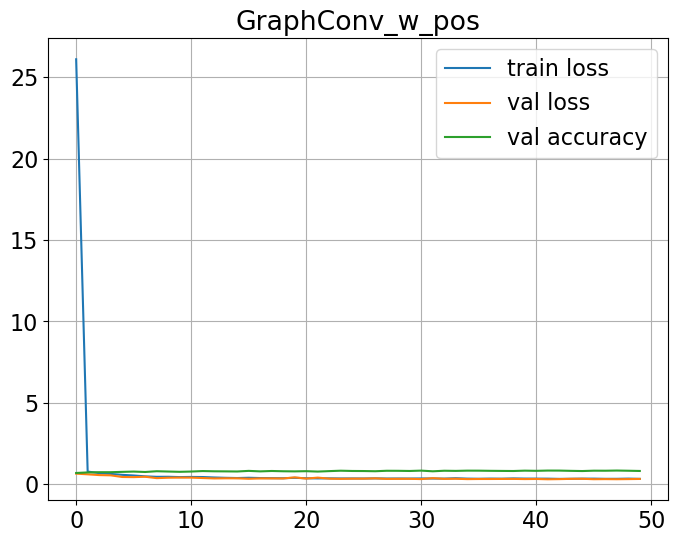

In [50]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.plot(val_accs)
plt.legend(["train loss", "val loss", "val accuracy"])
plt.title(label)
# plt.semilogy()
plt.savefig(f"{label}_losses")

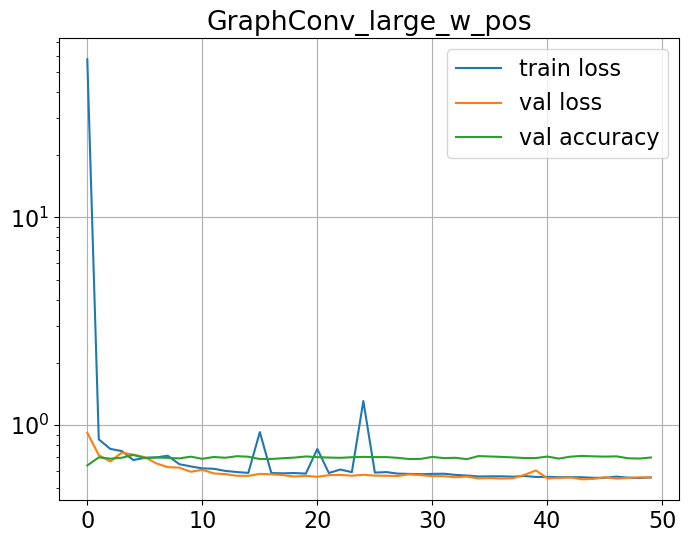

In [46]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.plot(val_accs)
plt.legend(["train loss", "val loss", "val accuracy"])
plt.title(label)
plt.semilogy()
plt.savefig(f"{label}_losses")

Text(0.5, 1.0, 'GraphConv_w_pos')

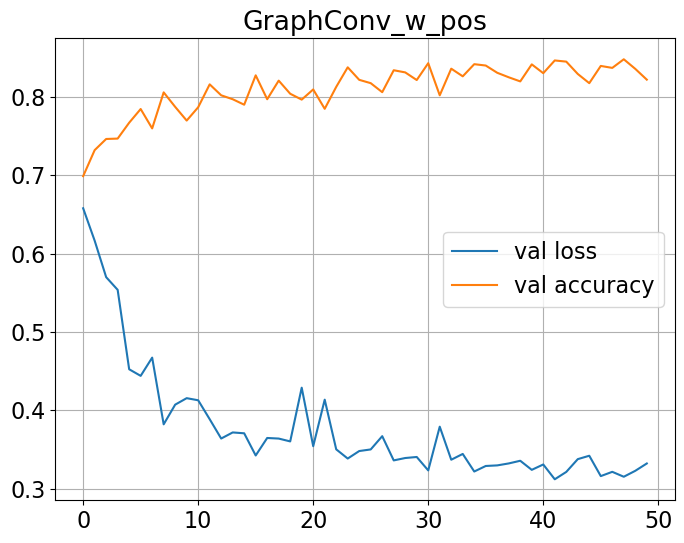

In [51]:
# plt.plot(train_losses)
plt.plot(val_losses)
plt.plot(val_accs)
plt.legend(["val loss", "val accuracy"])
plt.title(label)
# plt.semilogy()
# plt.savefig(f"{label}_losses")

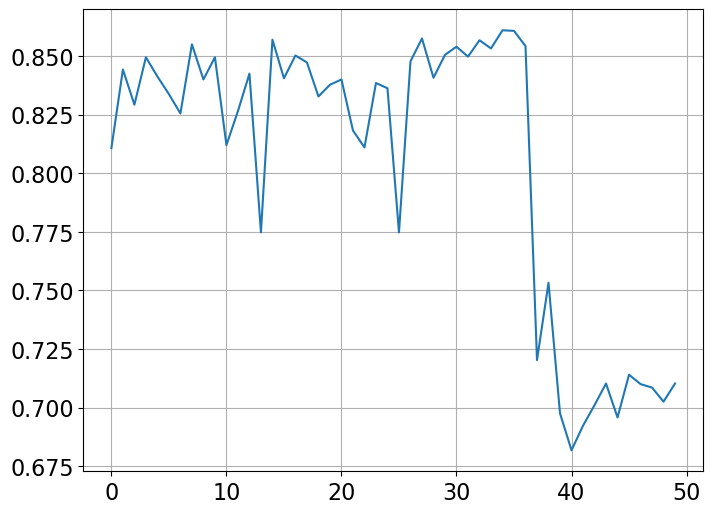

In [75]:
plt.plot(val_accs)